In [1]:
#Data available at
## Original source https://archive.ics.uci.edu/ml/datasets/Chronic_Kidney_Disease
## https://www.kaggle.com/mansoordaku/ckdisease?select=kidney_disease.csv
## Research problem :
    ### Prediction of Kidney disease from the diagnostic data
    ### Binary Classification Problem: ckd as having kidney disease and notckd with no kidney disease

In [197]:
# include all needed packages
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import seaborn as sns #visualisation
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score

In [45]:
# import and check data
df=pd.read_csv("kidney_disease.csv")
print(df.head())
print(df.shape)
print(df.columns)  #(400, 25)
# Remove missing values


    age    bp     sg   al   su     rbc        pc         pcc          ba  \
0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

     bgr  ...  pcv    wc   rc  htn   dm cad appet   pe  ane classification  
0  121.0  ...   44  7800  5.2  yes  yes  no  good   no   no            ckd  
1    NaN  ...   38  6000  NaN   no   no  no  good   no   no            ckd  
2  423.0  ...   31  7500  NaN   no  yes  no  poor   no  yes            ckd  
3  117.0  ...   32  6700  3.9  yes   no  no  poor  yes  yes            ckd  
4  106.0  ...   35  7300  4.6   no   no  no  good   no   no            ckd  

[5 rows x 25 columns]
(400, 25)
Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc

In [46]:
# Removing irrelevant variables
## I had an access to a kidney domain expert and found few variables are not a good indicator of the kidney disease 
## in this dataset. They are pc, pcc and ba. So I will remove that.

# Removing redundant variable
## Then I removed redundant variables. Redundant variables are those that points to the similar values.
## In this dataset -> Sugar(su) is same as Blood glucose(bgr) and Red blood cell count(rc), red blood cell count (rbc) is same indicator as Anemia (ane)
## We can remove su and rc, rbc. 
##However, before deleting the redundant values, we would see how many missing values are there in these colums.
## We will keep those variables from the redundant pairs where missing values are less.
## su has 49 missing values and bgr has 44, so we will drop su. Next rc has 130 missing values and ane
## ane has 1 so, I will drop rbc, rc here

df = df.drop(['pc','pcc','ba', 'su','rbc','rc'], axis=1)
df.shape  ## (400,19) 

(400, 19)

In [52]:
df=df.applymap(lambda x: x.strip() if isinstance(x, str) else x) # to strip any extra spaces in the values
df.shape

(400, 19)

In [53]:
# Now we will look at the missing values
df.isnull().sum()

age                 9
bp                 12
sg                 47
al                 46
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                70
wc                105
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

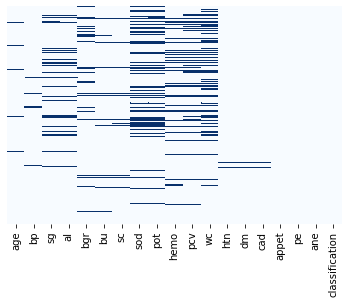

In [54]:
#This is a visualization of missing data in the dataset
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='Blues')

In [55]:
# There are many missing values per column, so we need to treat them
## % of values missing in each column
values = list()
cols = list()
for col in df.columns:
    missing = np.mean(df[col].isnull())*100
    cols.append(col)
    values.append(missing)
miss_df = pd.DataFrame()
miss_df['col'] = cols
miss_df['missing'] = values # percentage of missing values
miss_df.head()

,col,missing
0,age,2.25
1,bp,3.00
2,sg,11.75
3,al,11.50
4,bgr,11.00


In [56]:
# Plotting missing values
miss_df.hvplot.bar(x='col', y="missing")

:Bars   [col]   (missing)

In [57]:
## here the highest variables which are missing is pcv, sod, pot and wc. I will drop wc and pcv (not most important for this classification)and will impute
## the rest.
df=df.drop(['wc','pcv'], axis=1)
df.shape #400 * 17 
df.head()

,age,bp,sg,al,bgr,bu,sc,sod,pot,hemo,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,121.0,36.0,1.2,NaN,NaN,15.4,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,NaN,18.0,0.8,NaN,NaN,11.3,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,423.0,53.0,1.8,NaN,NaN,9.6,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,117.0,56.0,3.8,111.0,2.5,11.2,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,106.0,26.0,1.4,NaN,NaN,11.6,no,no,no,good,no,no,ckd


In [58]:
df.dtypes

age               float64
bp                float64
sg                float64
al                float64
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object

In [59]:
## Before imputing we need to divide the numerical from num numerical columns 
# select numerical columns
numeric = [x for x in df.columns if df[x].dtype == 'float64']
# select non numerical columns
non_numeric = [x for x in df.columns if df[x].dtype == object]
#print(non_numeric)
df_numeric = df[numeric]
df_non_numeric = df[non_numeric]
#print(df_non_numeric.head())

In [60]:
# impute missing values 
#create two DataFrames, one for each data type

imp_numeric = SimpleImputer(missing_values=np.nan, strategy='mean') # mean for numerical columns
df_imp_numeric = pd.DataFrame(imp_numeric.fit_transform(df_numeric), columns = df_numeric.columns) #only apply imputer to numeric columns

imp_non_numeric = SimpleImputer(missing_values=np.nan, strategy="most_frequent") # most frequent value for non numerical column
df_imp_non_numeric = pd.DataFrame(imp_non_numeric.fit_transform(df_non_numeric), columns = df_non_numeric.columns) 
#print(df_imp_numeric.head())
#print(df_imp_non_numeric.head())

#join the two dataframes back together
df_cleaned = pd.concat([df_imp_numeric, df_imp_non_numeric], axis = 1)
df_cleaned.head()

,age,bp,sg,al,bgr,bu,sc,sod,pot,hemo,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,121.000000,36.0,1.2,137.528754,4.627244,15.4,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,148.036517,18.0,0.8,137.528754,4.627244,11.3,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,423.000000,53.0,1.8,137.528754,4.627244,9.6,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,117.000000,56.0,3.8,111.000000,2.500000,11.2,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,106.000000,26.0,1.4,137.528754,4.627244,11.6,no,no,no,good,no,no,ckd


In [61]:
# lets look at the missing values in the cleaned dataset
df_cleaned.isnull().sum()

age               0
bp                0
sg                0
al                0
bgr               0
bu                0
sc                0
sod               0
pot               0
hemo              0
htn               0
dm                0
cad               0
appet             0
pe                0
ane               0
classification    0
dtype: int64

In [62]:
# Now lets look at the outliers
df_cleaned.hvplot.box(y=numeric,legend=False, invert=False)
# all the points out of the boxes are outliers as in bgr, bu, sc, sod, pot, but I would do another check with scatterplot matrix

:BoxWhisker   [Variable]   (value)

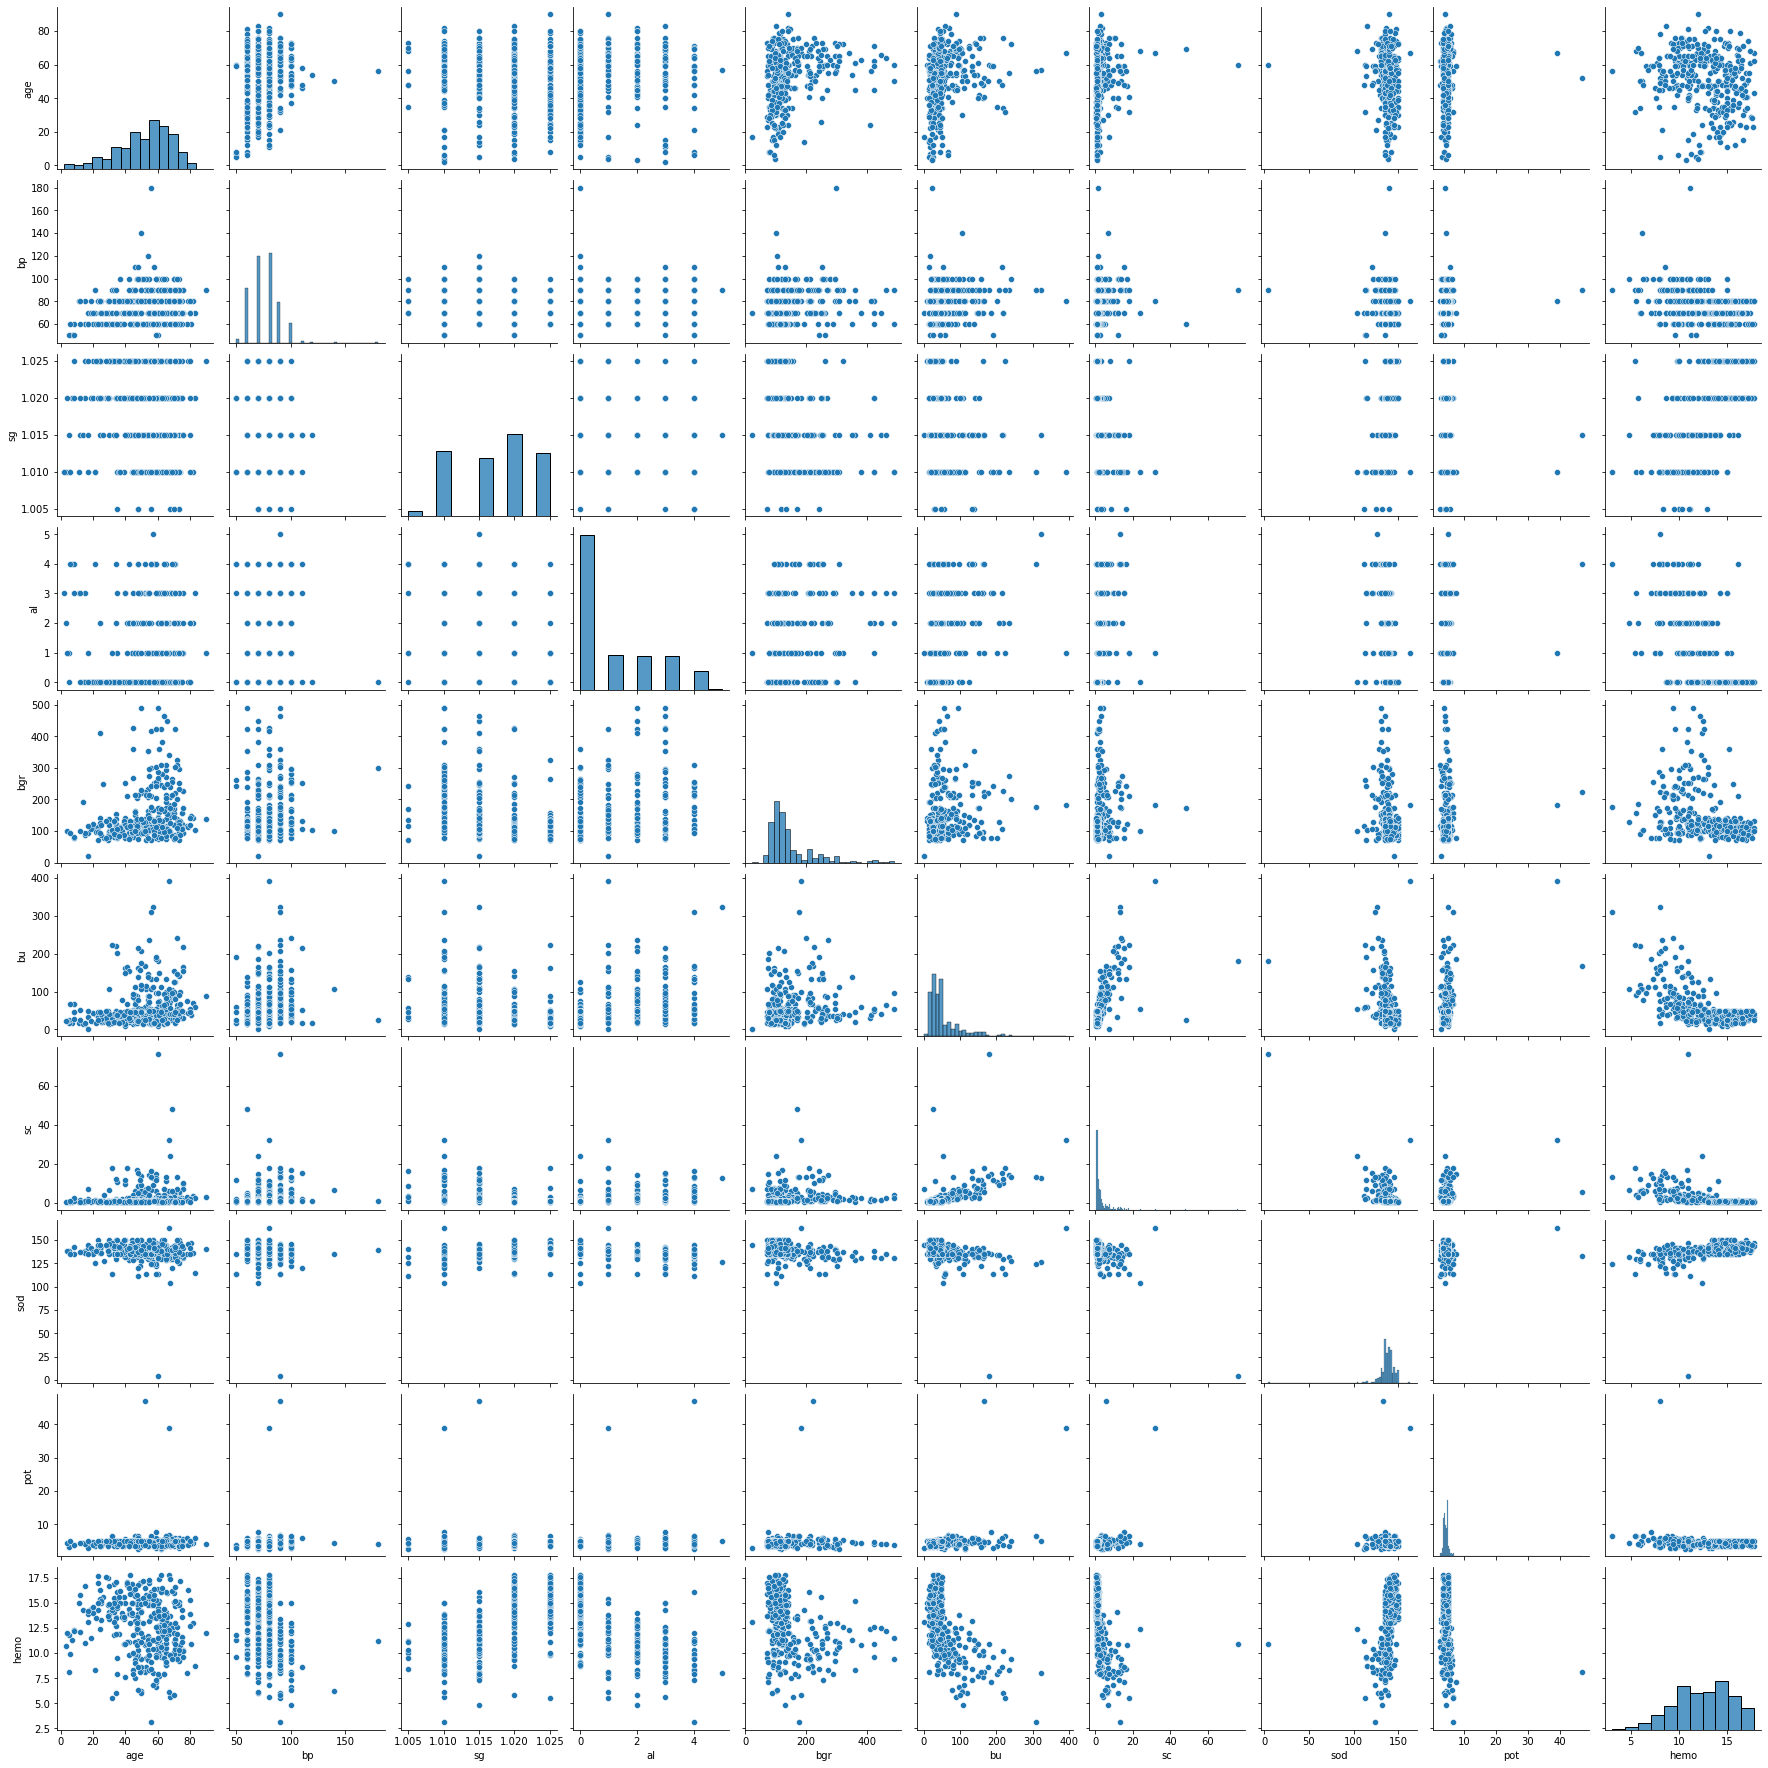

In [125]:
sns.pairplot(df[numeric])

In [27]:
# ! IMPORTANT Please not run this code, as it will delete half of the rows
###we can test it by using iqr outlier methods 

#q1 = df_cleaned[numeric].quantile(0.25)
#q3= df_cleaned[numeric].quantile(0.75)
#q3
#iqr = q3 - q1
#print(iqr)


#df2 = df_cleaned[~((df_cleaned[numeric] < (q1 - 1.5 * iqr)) |(df_cleaned[numeric] > (q3 + 1.5 * iqr))).any(axis=1)]
#df2.shape # 265, 19



In [64]:
# Outlier treatment
## By treating the outliers with the iqr method, half of the values are trimmed. As this dataset
## is already small I will manually remove the outliers
outliers = ['sod', 'sc','pot', 'bu', 'bp']

df_cleaned = df_cleaned.loc[df_cleaned.sod > 100]
df_cleaned = df_cleaned.loc[df_cleaned.sc < 20]
df_cleaned = df_cleaned.loc[df_cleaned.pot < 7]
df_cleaned = df_cleaned.loc[df_cleaned.bu < 280]
df_cleaned = df_cleaned.loc[df_cleaned.bp < 160]

df_cleaned.shape  # 391 * 17


(391, 17)

In [65]:
# Now lets look at the outliers columns again by plotting them
hvplot.scatter_matrix(df_cleaned[outliers])
## looks better now

:GridMatrix   [X,Y]
   :Histogram   [sod]   (sod_frequency)

In [66]:
## As not the dataset is clean, we can do further visual exploration

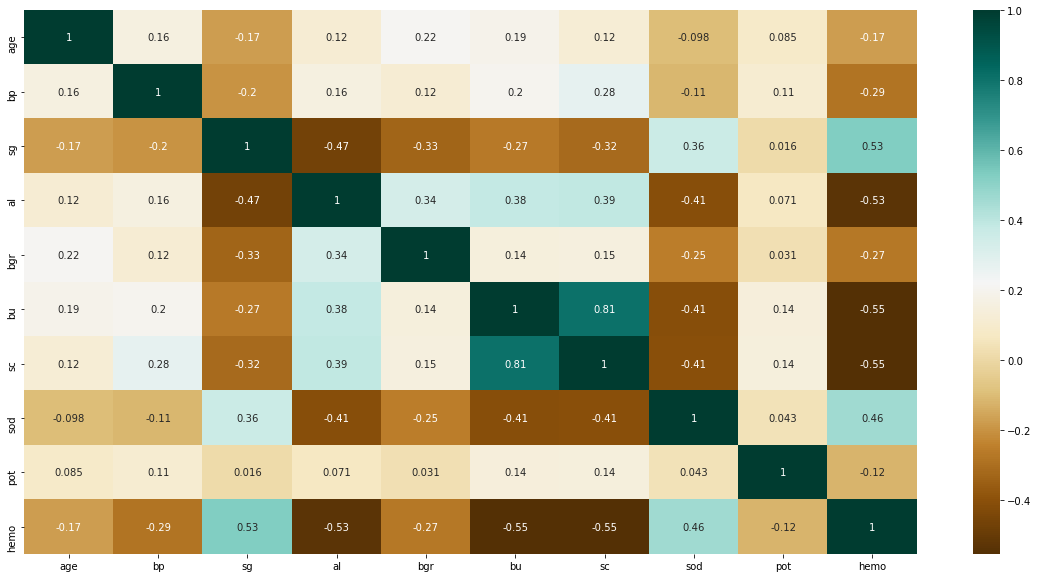

In [69]:
# Finding the relations between the variables.
plt.figure(figsize=(20,10))
c= df_cleaned.corr()
sns.heatmap(c,cmap='BrBG',annot=True)
#c
# shows positive and negative correlation among variables

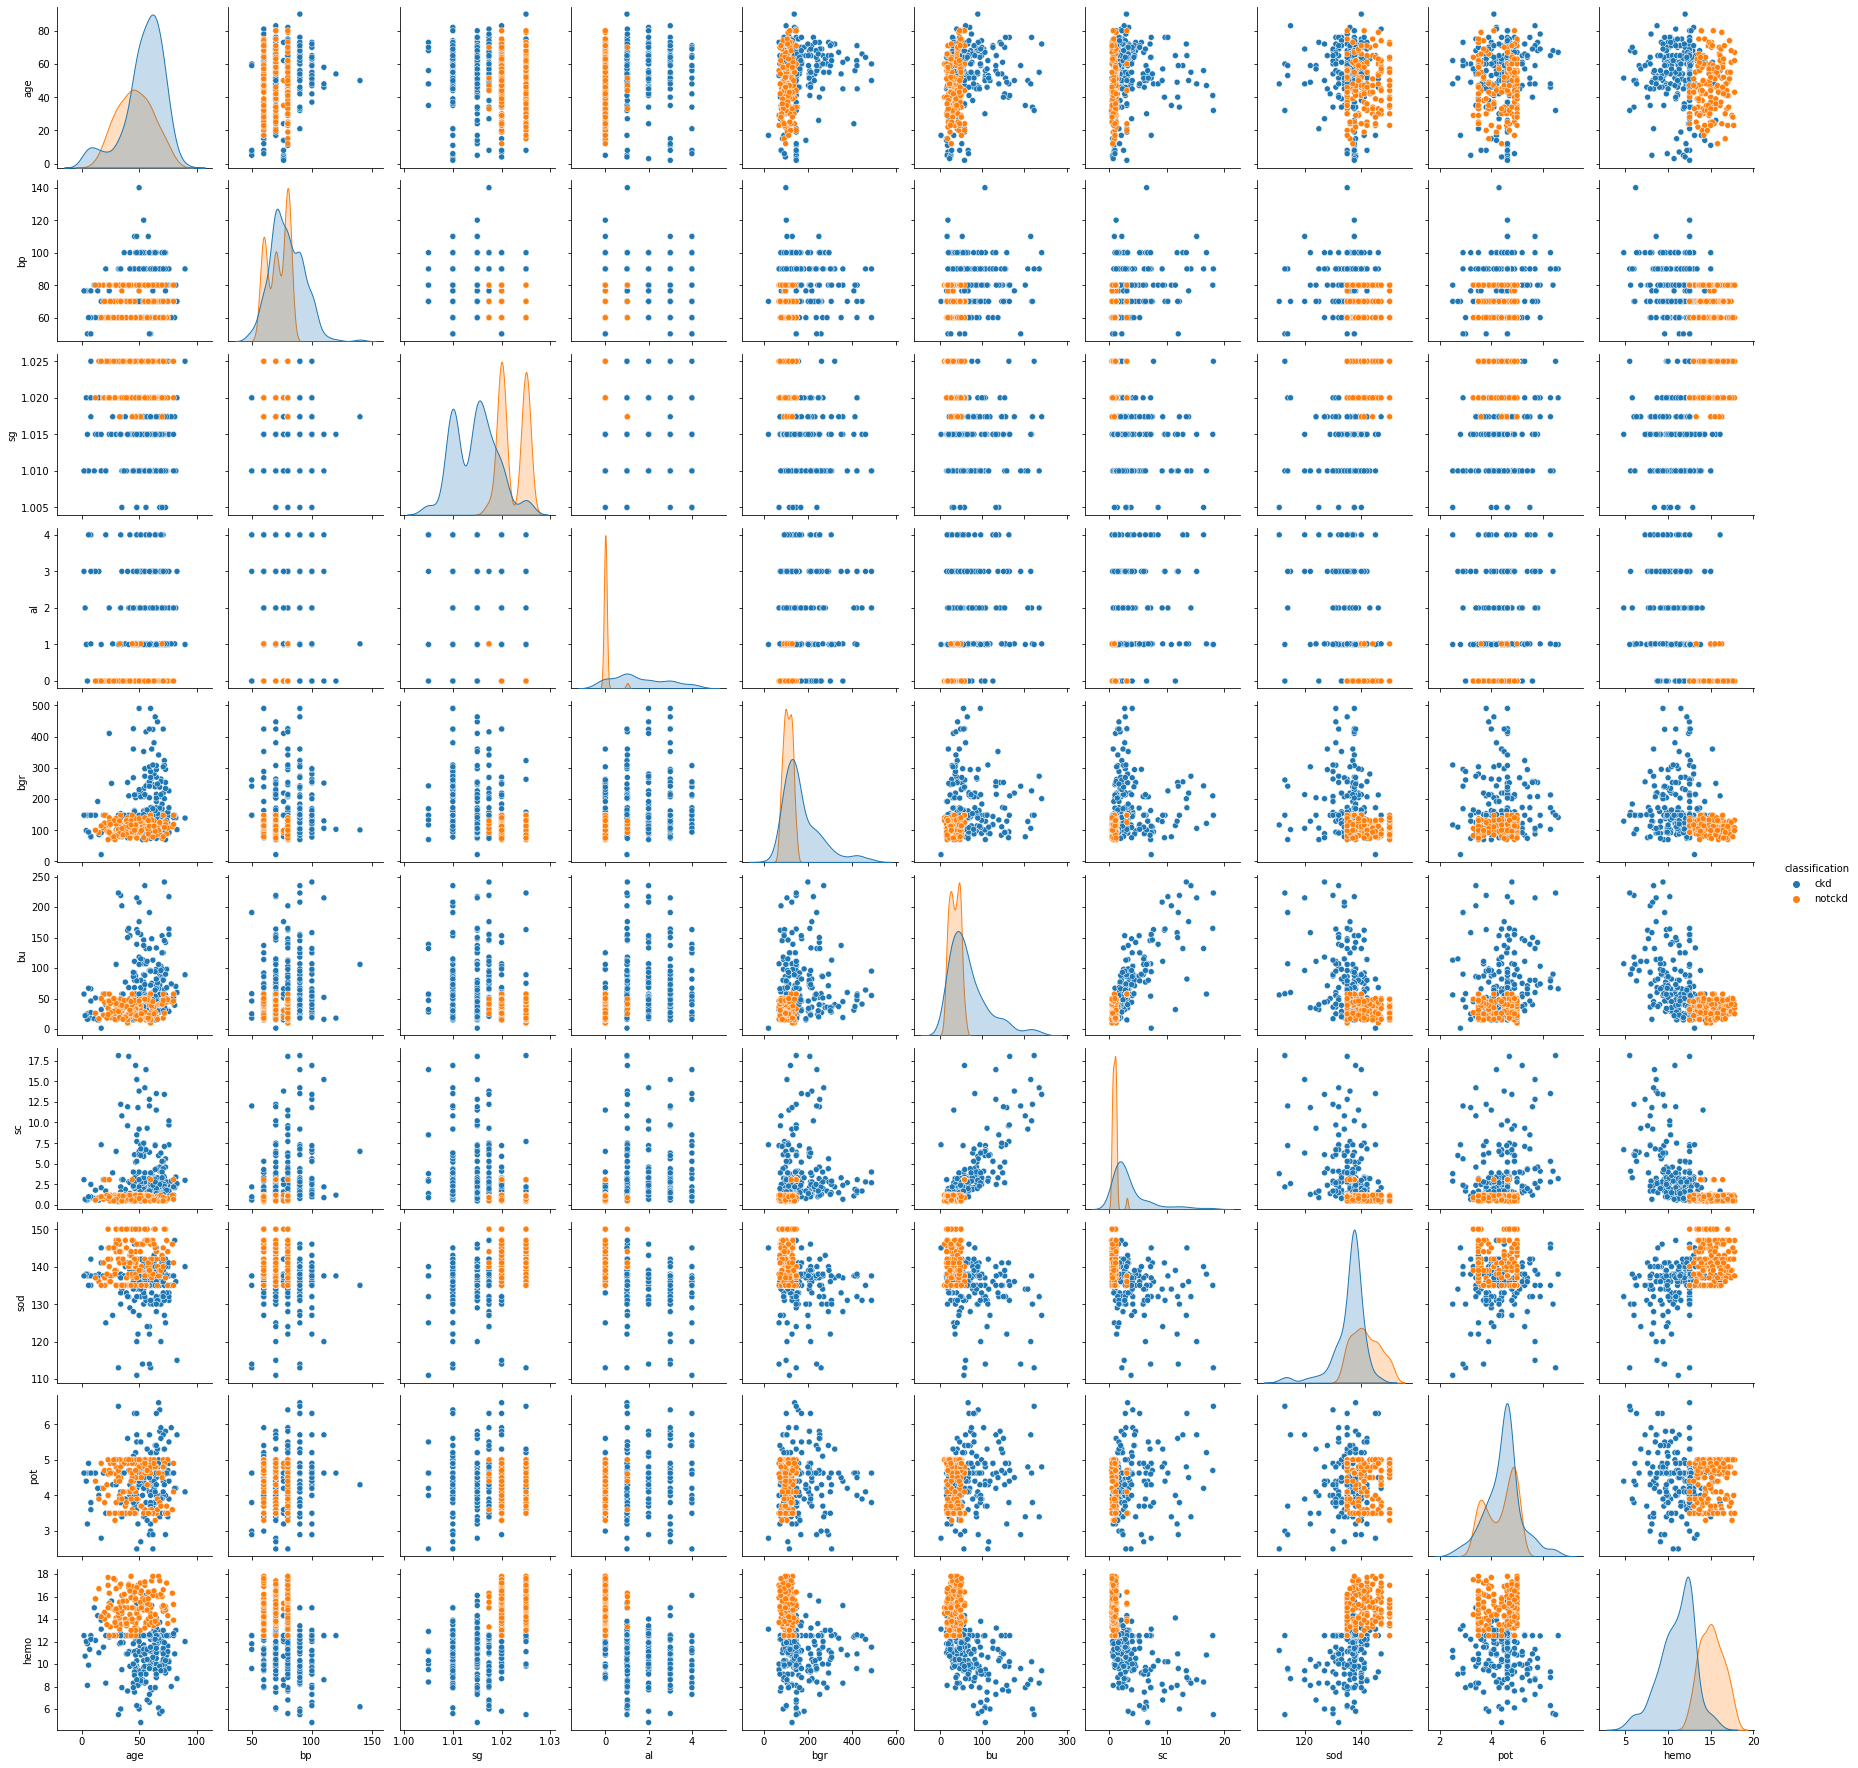

In [68]:
sns.pairplot(df_cleaned, hue="classification")
#This plot shows good partition between ckd and nonckd. For example with the plot of age and bgr 
#and bu and bgr, it shows that when the age is low bgr and bu are not a good indicator of ckd. 

In [70]:
# Before I start with the classification, I need to convert all non-numeric to numeric. 
df_cleaned[['htn','dm','cad','pe','ane']] = df_cleaned[['htn','dm','cad','pe','ane']].replace(to_replace={'yes':1,'no':0})
df_cleaned[['appet']] = df_cleaned[['appet']].replace(to_replace={'good':1,'poor':0})
df_cleaned['classification'] = df_cleaned['classification'].replace(to_replace={'ckd':1.0,'ckd\t':1.0,'notckd':0.0,'no':0.0})

In [74]:
print(df_cleaned.dtypes) # now all are numerics

age               float64
bp                float64
sg                float64
al                float64
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
htn                 int64
dm                  int64
cad                 int64
appet               int64
pe                  int64
ane                 int64
classification    float64
dtype: object


In [ ]:
# Here starts the modelling
### For binary classification problem, there are two classic classifiers that can be used 
###  1) logistic regression  2) SVM 

In [126]:
# partition test and training set. Test set 20%
X_train, X_test, Y_train, Y_test = train_test_split(df_cleaned.iloc[:,:-1], df_cleaned['classification'], test_size=0.20, random_state=44, stratify= df_cleaned['classification'])

In [175]:
# Logistic regression
lr = LogisticRegression()
lr.fit(X_train,Y_train)

c:\python\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [176]:
predict_lr = lr.predict(X_test)  ## predictions on the test set

In [177]:
print(classification_report(Y_test,predict_lr)) ## classification report

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.97        30
         1.0       0.96      1.00      0.98        49

    accuracy                           0.97        79
   macro avg       0.98      0.97      0.97        79
weighted avg       0.98      0.97      0.97        79



In [178]:
print(accuracy_score(Y_test,predict_lr)) ## accuracy

0.9746835443037974


In [179]:
print(confusion_matrix(Y_test,predict_lr))

[[28  2]
 [ 0 49]]


In [205]:
scores=cross_val_score(lr, X_train, Y_train, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

c:\python\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\python\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\python\lib\site-packages\sklearn\linear_model\_logistic.py:765: Conve

0.98 accuracy with a standard deviation of 0.03


In [198]:
#Running svm
svm = svm.SVC(kernel='linear',  C=1, random_state=42)
svm.fit(X_train,Y_train)

SVC(C=1, kernel='linear', random_state=42)

In [199]:
predict_svm = svm.predict(X_test) 

In [200]:
print(classification_report(Y_test,predict_svm))

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.97        30
         1.0       0.96      1.00      0.98        49

    accuracy                           0.97        79
   macro avg       0.98      0.97      0.97        79
weighted avg       0.98      0.97      0.97        79



In [201]:
print(accuracy_score(Y_test,predict_svm))

0.9746835443037974


In [202]:
print(confusion_matrix(Y_test,predict_svm))

[[28  2]
 [ 0 49]]


In [204]:
scores=cross_val_score(svm, X_train, Y_train, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.96 accuracy with a standard deviation of 0.01


In [207]:
# Now lets look at the features and its weight in both the classifiers
col=[i for i in df_cleaned.columns]
column=col[0:16]

# get features with weight from both the classifiers
df_lr=pd.Series(abs(lr.coef_[0]), 
          index=np.array(column)).nlargest(5)
df_svm=pd.Series(abs(svm.coef_[0]), 
          index=np.array(column)).nlargest(5)

# join these series into one dataframe
frame = { 'SVM': df_svm, 'LR': df_lr }
df_features = pd.DataFrame(frame)
df_features.index.name = "Features"
print(df_features.head())

               SVM        LR
Features                    
al        1.777746  1.813072
appet     1.000000       NaN
dm        1.202150  1.449724
hemo      1.069890  1.595284
htn       1.000000  1.169959


In [208]:
df_features.hvplot.barh(x='Features', y=['SVM', 'LR'],
                stacked=False, rot=90, width=500, legend='top_left')

:Bars   [Features,Variable]   (value)